# 🎨 Lekcja 48: Neural Style Transfer (Manipulacja Aktywacjami)

W tym notatniku zamienimy zwykłe zdjęcie w obraz malarski.
Nie używamy gotowych bibliotek. Zrobimy to na czystym PyTorch, manipulując aktywacjami sieci VGG19.

**Algorytm:**
1.  Bierzemy zdjęcie `Content` (Treść) i `Style` (Styl).
2.  Tworzymy losowy szum (lub kopię Contentu) -> `Target` (To będziemy trenować).
3.  Przepuszczamy wszystko przez zamrożone VGG19.
4.  **Content Loss:** `Target` musi mieć takie same aktywacje w głębokich warstwach jak `Content`.
5.  **Style Loss:** `Target` musi mieć taką samą **korelację kanałów** (Macierz Grama) we wszystkich warstwach jak `Style`.

To optymalizacja obrazu, a nie sieci.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IM_SIZE = 350 # Rozmiar obrazka (im mniej, tym szybciej)

# Normalizacja wymagana przez VGG
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

print(f"Malujemy na: {DEVICE}")

Malujemy na: cuda


## Ładowanie i Przetwarzanie Obrazów

Potrzebujemy funkcji, która pobierze obrazek, zmieni go w Tensor, znormalizuje, a na końcu... odwróci ten proces, żebyśmy mogli zobaczyć wynik.

In [6]:
def load_image(url, size=IM_SIZE):
    # --- WAŻNE: Przedstawiamy się jako przeglądarka ---
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'}
    
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content)).convert('RGB')
    except Exception as e:
        print(f"⚠️ Nie udało się pobrać obrazka z URL: {url}")
        print(f"Błąd: {e}")
        print("Generuję losowy szum zamiast obrazka, żeby kontynuować lekcję.")
        # Zwracamy losowy tensor (szum), żeby kod się nie wywalił
        return torch.randn(1, 3, size, size).to(DEVICE)
    
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(*stats)
    ])
    
    # Dodajemy wymiar batcha: [1, 3, H, W]
    return transform(image).unsqueeze(0).to(DEVICE)

def tensor_to_image(tensor):
    # Klonujemy i zdejmujemy z GPU
    image = tensor.cpu().clone().squeeze(0)
    
    # Odwracamy normalizację (x * std + mean)
    # Ręcznie dla każdego kanału
    mean = torch.tensor(stats[0]).view(3, 1, 1)
    std = torch.tensor(stats[1]).view(3, 1, 1)
    image = image * std + mean
    
    # Przycinamy do [0, 1]
    image = image.clamp(0, 1)
    
    return transforms.ToPILImage()(image)

# Pobieramy obrazy
url_content = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg" # Kot
url_style = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/687px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg" # Mona Lisa

print("Pobieranie Content...")
content_img = load_image(url_content)
print("Pobieranie Style...")
style_img = load_image(url_style)

# Płótno, które będziemy malować (zaczynamy od kopii Contentu, żeby było szybciej)
generated_img = content_img.clone().requires_grad_(True)

print("Zdjęcia gotowe.")

Pobieranie Content...
Pobieranie Style...
Zdjęcia gotowe.


## Matematyka Stylu: Macierz Grama

Co to jest styl?
W Deep Learningu styl to **korelacja między filtrami**.
*   Jeśli filtr "pionowe kreski" aktywuje się często razem z filtrem "kolor niebieski", to jest to styl (np. deszcz).
*   Macierz Grama to iloczyn tensorów: $G = F \cdot F^T$. Spłaszcza ona przestrzeń i usuwa informację "gdzie" coś jest, zostawiając tylko "co z czym występuje".

In [7]:
def gram_matrix(tensor):
    # tensor: [Batch, Channel, Height, Width]
    b, c, h, w = tensor.size()
    
    # Spłaszczamy H i W -> [Batch, Channel, H*W]
    tensor = tensor.view(b, c, h * w)
    
    # Mnożymy macierz przez jej transpozycję
    # [b, c, hw] @ [b, hw, c] -> [b, c, c]
    gram = torch.bmm(tensor, tensor.transpose(1, 2))
    
    # Normalizujemy przez liczbę pikseli (żeby styl nie zależał od rozmiaru)
    return gram / (c * h * w)

## Model: VGG19 (Feature Extractor)

Nie potrzebujemy całej sieci (klasyfikacji). Potrzebujemy tylko jej "oczu".
Wytniemy VGG19 i będziemy wyciągać aktywacje z konkretnych warstw:
*   `conv1_1, conv2_1, conv3_1...` -> Odpowiedzialne za Styl (tekstura).
*   `conv4_2` -> Odpowiedzialna za Treść (kształty).

In [4]:
class VGGFeatures(nn.Module):
    def __init__(self):
        super().__init__()
        # Ładujemy wytrenowane VGG
        vgg = models.vgg19(weights='IMAGENET1K_V1').features
        
        # Wybieramy indeksy warstw, które nas interesują (z dokumentacji VGG)
        # 0: conv1_1, 5: conv2_1, 10: conv3_1, 19: conv4_1, 21: conv4_2 (Content), 28: conv5_1
        self.chosen_layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}
        
        # Bierzemy tylko potrzebny kawałek sieci (do warstwy 29)
        self.model = vgg[:29].to(DEVICE).eval()
        
        # Mrozimy wagi (nie trenujemy VGG!)
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = {}
        # Przepuszczamy obrazek warstwa po warstwie
        for name, layer in self.model.named_children():
            x = layer(x)
            # Jeśli to jedna z wybranych warstw, zapisujemy wynik
            if name in self.chosen_layers:
                features[self.chosen_layers[name]] = x
        return features

model = VGGFeatures()
print("Ekstraktor cech gotowy.")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\takze/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [02:51<00:00, 3.34MB/s] 


Ekstraktor cech gotowy.


In [8]:
# PRZYGOTOWANIE TRENINGU

# 1. Obliczamy cechy dla oryginałów (to są nasze cele)
target_content_features = model(content_img)
target_style_features = model(style_img)

# 2. Obliczamy Macierze Grama dla stylu
style_grams = {layer: gram_matrix(target_style_features[layer]) for layer in target_style_features}

# 3. Wagi (Co jest ważniejsze? Styl czy Treść?)
style_weights = {'conv1_1': 1.0, 'conv2_1': 0.8, 'conv3_1': 0.5, 'conv4_1': 0.3, 'conv5_1': 0.1}
content_weight = 1     # alpha
style_weight = 1e6     # beta (Styl musi być mocniejszy, bo Gramy są małe)

# Optymalizator - trenujemy generated_img!
optimizer = optim.Adam([generated_img], lr=0.003)

print("Start malowania...")

# PĘTLA TRENINGOWA
for step in range(2000):
    # 1. Wyciągamy cechy z naszego obrazka
    gen_features = model(generated_img)
    
    content_loss = 0
    style_loss = 0
    
    # 2. Content Loss (tylko na warstwie conv4_2)
    content_loss += torch.mean((gen_features['conv4_2'] - target_content_features['conv4_2']) ** 2)
    
    # 3. Style Loss (na wszystkich warstwach stylowych)
    for layer, weight in style_weights.items():
        gen_gram = gram_matrix(gen_features[layer])
        target_gram = style_grams[layer]
        layer_style_loss = torch.mean((gen_gram - target_gram) ** 2)
        style_loss += layer_style_loss * weight
    
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # 4. Update pikseli
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if step % 500 == 0:
        print(f"Krok {step}: Loss {total_loss.item():.2f}")

print("✅ Obraz gotowy.")

Start malowania...
Krok 0: Loss 141.73
Krok 500: Loss 7.17
Krok 1000: Loss 6.07
Krok 1500: Loss 5.44
✅ Obraz gotowy.


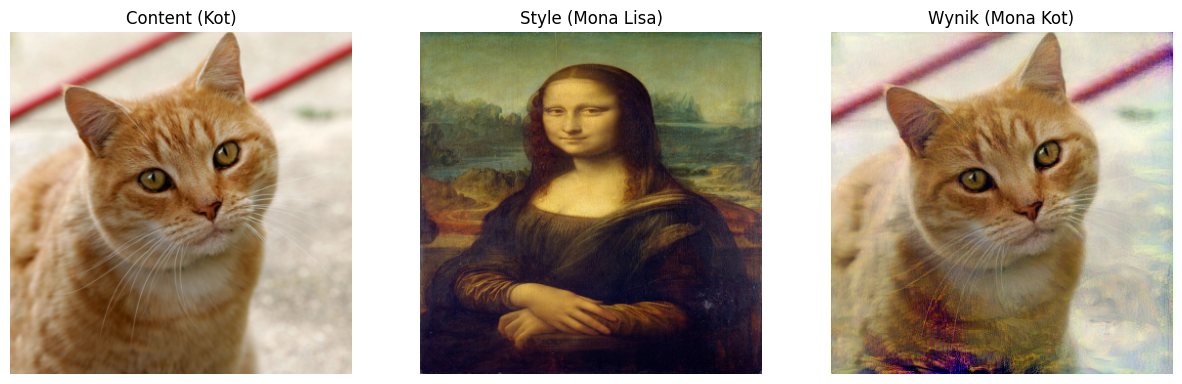

In [9]:
# WIZUALIZACJA
final_image = tensor_to_image(generated_img)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(tensor_to_image(content_img))
plt.title("Content (Kot)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(tensor_to_image(style_img))
plt.title("Style (Mona Lisa)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(final_image)
plt.title("Wynik (Mona Kot)")
plt.axis('off')

plt.show()

## 🥋 Black Belt Summary

1.  **Odwrócenie ról:** W NST to **dane (piksele)** mają `requires_grad=True`, a wagi sieci są stałe.
2.  **Macierz Grama:** To matematyczny sposób na opisanie "tekstury" bez dbania o kształt. Mówi ona: "Tutaj czerwony często występuje obok pionowych kresek".
3.  **Optymalizacja:** Użyliśmy Adama dla prostoty, ale profesjonalne implementacje używają **L-BFGS** (optymalizator drugiego rzędu), który daje o wiele lepsze rezultaty przy generowaniu obrazów.